In [25]:
%cd ~/cdv/

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'

import numpy as np
import jax.numpy as jnp
import jax
import jax.random as jr
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = True
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

/home/nmiklaucic/cdv


/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from pathlib import Path
import pyrallis
from facet.config import MainConfig
import orbax.checkpoint as ocp

from facet.training_state import TrainingRun
from facet.checkpointing import best_ckpt

# run_dir = Path('logs') / '10-15-01-06_751'
run_dir = Path('logs') / '11-08-19-53_500'
# run_dir = Path('logs') / 'enb-86'

with open(run_dir / 'config.toml') as conf_file:
    config = pyrallis.cfgparsing.load(MainConfig, conf_file)

model = config.build_regressor()


ckpt = best_ckpt(run_dir)
ckpt = jax.tree.map(lambda x: x if isinstance(x, (float, int)) else x.astype(jnp.float32), ckpt)
# model = model.bind(ckpt['state']['params'])

In [32]:
from facet.data.dataset import load_file
cg = load_file(config, group_num=2)
cg

CrystalGraphs(nodes=(1024, 3), edges=(1024, 32), graphs=(32,))

In [33]:
from facet.layers import Context
from facet.regression import EFSWrapper
ctx = Context(training=False)

raw_params = ckpt['state']['params']
ema_params = ckpt['state']['opt_state'][2]['ema']

out = EFSWrapper()(model.apply, ema_params, cg=cg, ctx=ctx)
out


EFSOutput(
    energy=Array([[-5.541932  ],
       [-5.6015916 ],
       [-8.702359  ],
       [-6.8489895 ],
       [-7.509343  ],
       [-8.387628  ],
       [-7.2625656 ],
       [-6.0519185 ],
       [-2.930354  ],
       [-2.9281373 ],
       [-7.6060786 ],
       [-7.4052444 ],
       [-9.209475  ],
       [-8.0269165 ],
       [-7.668445  ],
       [-5.9169917 ],
       [-2.18415   ],
       [-3.660702  ],
       [-6.2351284 ],
       [-6.511806  ],
       [-8.830331  ],
       [-3.9106195 ],
       [-3.2405577 ],
       [-7.306643  ],
       [-8.734775  ],
       [-3.9402268 ],
       [-0.81307775],
       [-4.9675827 ],
       [-0.78971606],
       [-0.6897897 ],
       [ 0.        ],
       [ 0.        ]], dtype=float32),
    force=Array([[ 0.06021235, -0.02381758, -0.01598296],
       [ 0.06021226,  0.02381426,  0.0159864 ],
       [-0.06030993, -0.02332661,  0.01578423],
       ...,
       [-0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.     

In [44]:
from ase import units as U



node_pad = cg.node_pad
f = cg.target_data.force[node_pad].reshape(-1, 3)
fhat = out.force[node_pad].reshape(-1, 3)
e = cg.target_data.e_form[cg.padding_mask].reshape(-1)
ehat = out.energy[cg.padding_mask].reshape(-1)
s = cg.target_data.stress[cg.padding_mask]
shat = out.stress[cg.padding_mask]

def l1_loss(x, y: jax.Array | int = 0):
    return jnp.mean(jnp.abs(x - y))

def med_ae(x, y: jax.Array | int = 0):
    return jnp.median(jnp.abs(x - y).reshape(-1))

print('force', l1_loss(fhat, f), l1_loss(f), sep='\t')
print('energy', l1_loss(ehat, e), l1_loss(e), sep='\t')
print('stress', l1_loss(shat, s), l1_loss(s), sep='\t')

force	0.12164566	0.21452071
energy	0.17639449	5.58088
stress	14.610129	14.563433


In [35]:
def energy_fn(cart, lat):
    energy = model.apply(
        ema_params,
        cg.replace(
            nodes=cg.nodes.replace(cart=cart), graph_data=cg.graph_data.replace(lat=lat)
        ),
        ctx=ctx
    )
    return jnp.sum(energy, where=cg.padding_mask), energy


(fgrad, sgrad), energy = jax.grad(energy_fn, argnums=(0, 1), has_aux=True)(
    cg.nodes.cart, cg.graph_data.lat
)

In [36]:
import e3nn_jax as e3nn
det = jax.vmap(jnp.linalg.det)(cg.graph_data.lat)[:, None, None]  # [n_graphs, 1, 1]
det = jnp.where(det > 0.0, det, 1.0)  # dummy graphs have det = 0

minus_forces = fgrad
pseudo_stress = sgrad

stress_cell = (
    jnp.transpose(pseudo_stress, (0, 2, 1)) @ cg.graph_data.lat
)  # [n_graphs, 3, 3]
stress_forces = e3nn.scatter_sum(
    jnp.einsum("iu,iv->iuv", minus_forces, cg.nodes.cart),
    nel=cg.n_node,
)  # [n_graphs, 3, 3]
viriel = stress_cell + stress_forces  # NOTE: sign suggested by Ilyes Batatia
stress = -1.0 / det * viriel
stress = stress[cg.padding_mask]

In [46]:
med_ae(stress, s), med_ae(s)

(Array(0.34281254, dtype=float32), Array(0.34226674, dtype=float32))

0.44785944


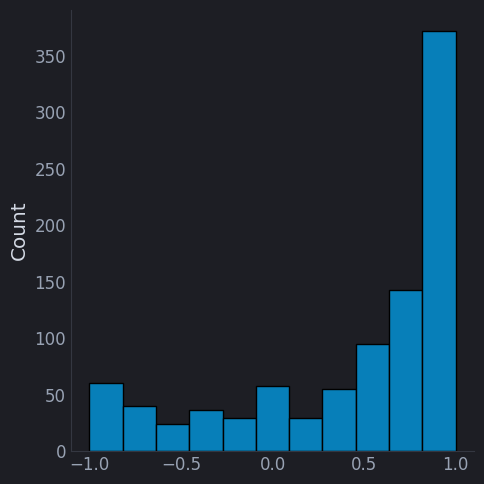

In [42]:
@jax.vmap
def cos_dist(x1, x2):
    return jnp.dot(x1, x2) / jnp.sqrt(jnp.dot(x1, x1) * jnp.dot(x2, x2) + 1e-10)

fdist = cos_dist(f, fhat)
print(fdist.mean())
sns.displot(fdist)

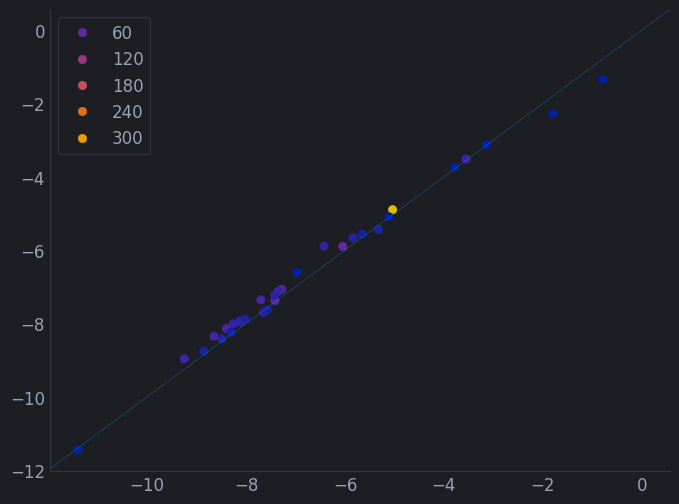

In [31]:
sns.scatterplot(x=ehat, y=e, hue=cg.n_node[cg.padding_mask], palette='rho_sequential', ec=None)
plt.axline((0, 0), slope=1, lw=0.2)

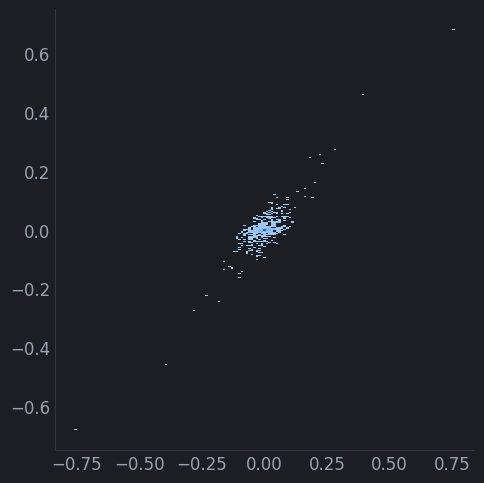

In [50]:
fdiff = f - fhat
fdnorm = jnp.linalg.vector_norm(fdiff, axis=1)

mask = jnp.abs(fdnorm) < 0.1
sns.displot(x=f[mask].reshape(-1), y=fhat[mask].reshape(-1))

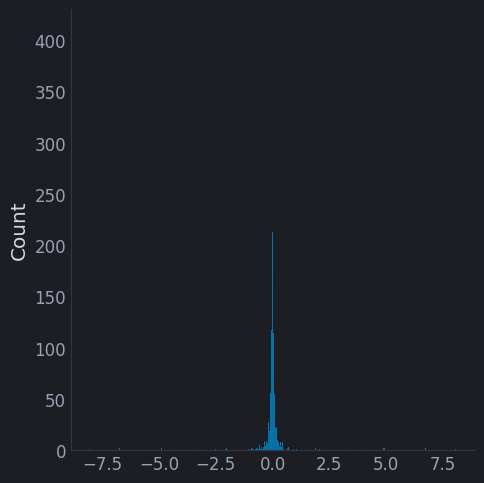

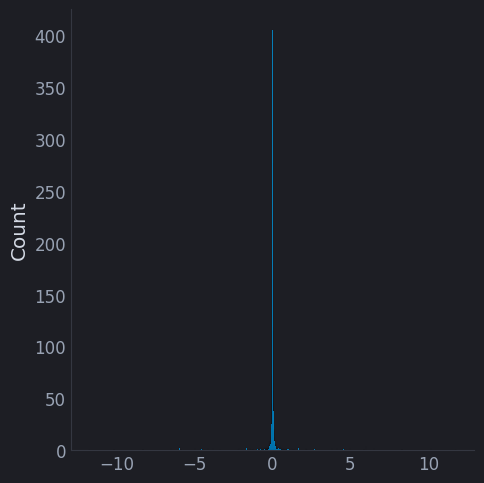

In [52]:
sns.displot(f.reshape(-1))

sns.displot(fhat.reshape(-1))

In [9]:
l1_loss(f)

Array(0.04981579, dtype=float32)

In [87]:
vol = jnp.linalg.det(cg.graph_data.lat[1])
(-shat[1]) * cg.n_node[1]


Array([[-0.10890532,  0.00817202, -0.03942756],
       [-0.01127376,  0.18733723, -0.05919498],
       [ 0.02392958, -0.00932203,  0.14120552]], dtype=float32)

In [92]:
s[0]


Array([[-0.60424715,  0.        ,  0.        ],
       [-0.        , -0.60424715, -0.        ],
       [ 0.        , -0.        , -0.60424715]], dtype=float32)

In [115]:
import e3nn_jax as e3nn
s_forces = e3nn.scatter_sum(
    jnp.einsum("iu,iv->iuv", -out.force, cg.nodes.cart),
    nel=cg.n_node,
)

vols = jnp.linalg.det(cg.graph_data.lat[cg.padding_mask])[:, None, None]

shat2 = (-0.1 * (s_forces[cg.padding_mask] - shat))

l1_loss(shat2, s)

Array(2.8824584, dtype=float32)

In [111]:
shat2


Array([[[-6.82180226e-01,  5.21102250e-02, -1.55381334e-04],
        [ 7.86673103e-04, -6.93698823e-01,  1.54064153e-04],
        [-2.03943625e-02, -1.98779013e-02, -7.25386918e-01]],

       [[-3.64974514e-02, -1.59305617e-01,  1.03405789e-02],
        [ 4.09099227e-03,  1.42291594e+00, -2.72516429e-01],
        [-5.24951458e-01, -6.91891611e-01,  9.62256253e-01]],

       [[-5.04558861e-01,  7.28574872e-01,  1.82530209e-01],
        [ 2.07458183e-01, -1.00633371e+00,  1.20740972e-01],
        [ 2.94208616e-01,  5.05794048e-01,  4.97382075e-01]],

       [[ 9.91178080e-02,  2.25008893e+00,  6.83501911e+00],
        [ 8.62053990e-01, -2.38283277e+00,  4.54934269e-01],
        [ 3.83615422e+00, -7.51134753e-01, -3.47551084e+00]],

       [[ 1.84880006e+00, -1.23305130e+00,  1.97775289e-01],
        [-2.26320490e-01, -2.26188108e-01,  3.11821371e-01],
        [-6.85291469e-01,  5.40968895e-01, -2.96678126e-01]],

       [[ 6.13155305e-01, -3.21964383e-01,  7.14292079e-02],
        [ 5.6

In [109]:
s


Array([[[-6.0424715e-01,  0.0000000e+00,  0.0000000e+00],
        [-0.0000000e+00, -6.0424715e-01, -0.0000000e+00],
        [ 0.0000000e+00, -0.0000000e+00, -6.0424715e-01]],

       [[ 1.0462394e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  2.8096368e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  2.8096368e+00]],

       [[ 3.3103592e+00,  8.9109997e-04,  8.7364800e-03],
        [ 8.9109997e-04,  3.3401010e+00,  3.8545862e-02],
        [ 8.7365601e-03,  3.8545821e-02,  2.1181519e+00]],

       [[-6.9081502e+00,  0.0000000e+00,  1.7676691e+00],
        [ 0.0000000e+00, -3.1795950e+00,  0.0000000e+00],
        [ 1.7676692e+00,  0.0000000e+00, -4.2425270e+00]],

       [[-1.0880770e-01, -1.2903541e-01,  0.0000000e+00],
        [-1.2902828e-01,  6.1132740e-02,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00, -5.8678418e-02]],

       [[-3.7215585e-01, -0.0000000e+00,  0.0000000e+00],
        [-0.0000000e+00, -3.7215585e-01,  0.0000000e+00],
   

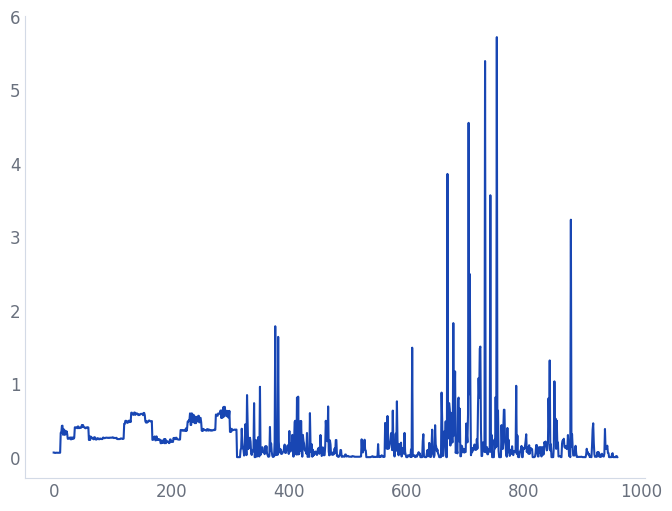

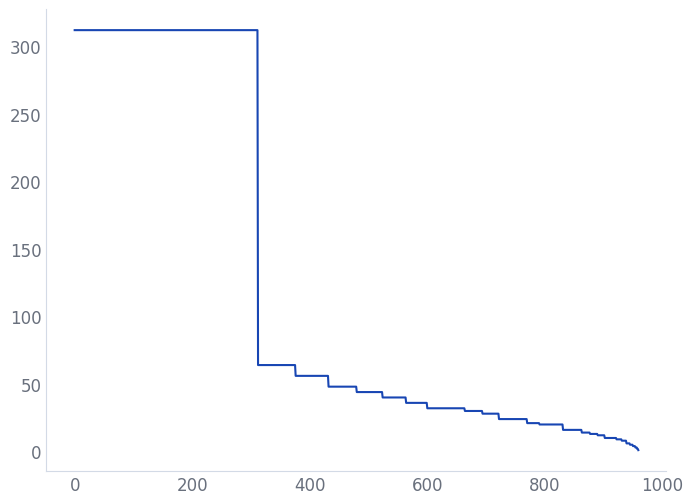

In [65]:
plt.plot((jnp.abs(f) / (jnp.abs(fhat) + 1e-2)).mean(axis=1))
plt.show()
plt.plot(cg.n_node[cg.nodes.graph_i][node_pad])

In [42]:
l1_loss(fhat)

Array(0.5799207, dtype=float32)

In [43]:
l1_loss(f)

Array(0.04981579, dtype=float32)

In [41]:
l1_loss(-fhat, f)

Array(0.5978559, dtype=float32)

In [17]:
l1_loss(out.energy, cg.target_data.e_form)

Array(2.1459146, dtype=float32)

In [13]:
l1_loss(f)

Array(0.6943037, dtype=float32)

In [ ]:
l1_loss(fhat, f)

In [85]:
jnp.linalg.det(cg.graph_data.lat)


Array([2696.727   ,  992.36285 ,  620.93396 ,  776.3881  , 1254.885   ,
        445.16635 ,  662.7077  ,  448.4857  ,  603.1233  ,  495.03308 ,
        755.0803  ,  326.15817 ,  325.39355 ,  279.91446 ,  277.42963 ,
        258.77118 ,  274.63596 ,  342.94644 ,  159.77986 ,  166.9987  ,
        158.49847 ,  213.66805 ,  142.81676 ,  195.74626 ,  103.411896,
        204.39546 ,   65.49931 ,   44.829044,   61.68288 ,   52.1802  ,
         26.543814,    0.      ], dtype=float32)

In [ ]:
loss = config.train.loss.efs_loss(cg, out)

In [35]:
cg.nodes.graph_i[:272]


Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [93]:
from pymatgen.core import Lattice

lat = Lattice(cg.graph_data.lat[0])

In [97]:
volume = jnp.abs(jnp.linalg.det(cg.graph_data.lat))[..., None, None]
stress_cell = (0.1 * out.stress / jnp.where(volume == 0, jnp.ones_like(volume), volume))

15.490802


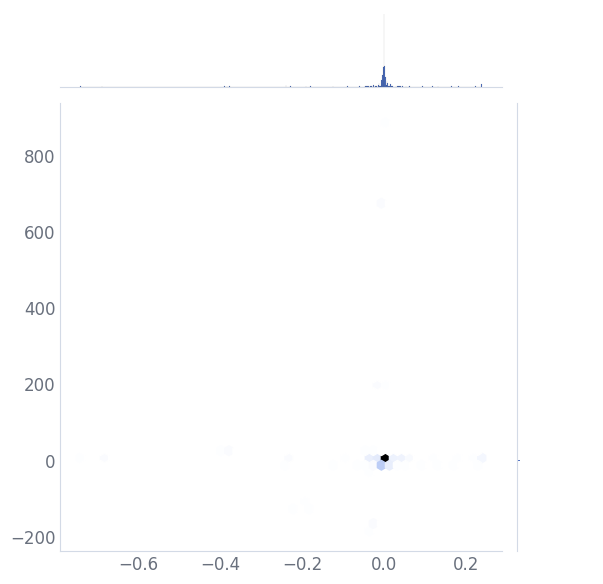

In [98]:
y = cg.target_data.stress[cg.padding_mask]
volume = jnp.linalg.det(cg.graph_data.lat)[..., None, None]
yhat = stress_cell[cg.padding_mask]

z = y - yhat
# z = z[cg.padding_mask[cg.nodes.graph_i]]
print(jnp.mean(jnp.abs(z)))
sns.jointplot(x=yhat.reshape(-1), y=y.reshape(-1), kind='hex')

In [40]:
cg.graph_data.lat[1]


Array([[10.297847  ,  0.        , -2.931051  ],
       [ 0.        ,  9.247357  ,  0.        ],
       [-0.02958372,  0.        , 10.42935   ]], dtype=float32)

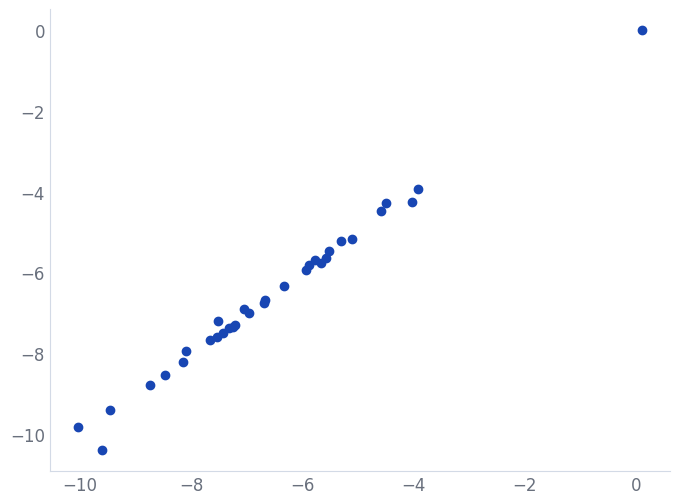

In [13]:
plt.scatter(out.energy, cg.e_form)